# 🎯 Supervised Model - Complete Pipeline Visualization

Visualizes the complete supervised model training pipeline:
1. Model Comparison (Linear, Ridge, Random Forest)
2. Best Model Selection
3. Hyperparameter Optimization
4. Final Model Performance

This notebook mirrors the workflow in `main.py`

In [1]:
# Import libraries
import sys
sys.path.insert(0, '../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Libraries loaded successfully")

Libraries loaded successfully


## Step 1: Load and Prepare Data

In [ ]:
from utils.movie_data_loader import MovieDataLoader
from models.supervised.feature_engineering import FeatureEngineer

# Load data
print("Loading data...")
loader = MovieDataLoader()
df = loader.get_supervised_data()

# Engineer features
print("Engineering features...")
engineer = FeatureEngineer()
df = engineer.create_all_features(df)
X, y = engineer.prepare_features_and_target(df)
X_scaled = engineer.fit_transform(X)

print(f"Data ready: {len(df):,} movies, {len(engineer.feature_names)} features")
print(f"Target range: {y.min():.1f} - {y.max():.1f}")
print(f"Target mean: {y.mean():.2f} ± {y.std():.2f}")

Loading data...
Engineering features...

Data ready: 9,660 movies, 31 features
Target range: 0.0 - 100.0
Target mean: 63.52 ± 13.59


## Step 2: Train and Compare All Models

In [ ]:
from models.supervised.trainer import QualityModelTrainer

# Models to test
models_to_test = {
    'Linear Regression': 'linear',
    'Ridge Regression': 'ridge',
    'Random Forest': 'random_forest'
}

results = {}
trained_models = {}

print("Training models...")
for model_name, model_type in models_to_test.items():
    print(f"Training {model_name}...", end=" ")
    trainer = QualityModelTrainer(model_type=model_type)
    metrics = trainer.train_and_evaluate(X_scaled, y.values)
    results[model_name] = metrics
    trained_models[model_name] = trainer
    print(f"R²={metrics['test_r2']:.4f}")

print("All models trained!")

Training models...

Training Linear Regression... R²=0.3157
Training Ridge Regression... R²=0.3157
Training Random Forest... R²=0.5657

All models trained!


### Visualize Model Comparison

In [ ]:
# Create comparison dataframe
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df[['test_r2', 'test_rmse', 'test_mae']]
comparison_df.columns = ['R²', 'RMSE', 'MAE']

print("MODEL COMPARISON")
print("="*60)
print(comparison_df.to_string())

# Find best model
best_model_name = comparison_df['R²'].idxmax()
print(f"Best Model: {best_model_name} (R²={comparison_df.loc[best_model_name, 'R²']:.4f})")

MODEL COMPARISON
                         R²       RMSE       MAE
Linear Regression  0.315730  11.053398  8.071497
Ridge Regression   0.315742  11.053296  8.071157
Random Forest      0.565741   8.805550  6.149753

Best Model: Random Forest (R²=0.5657)


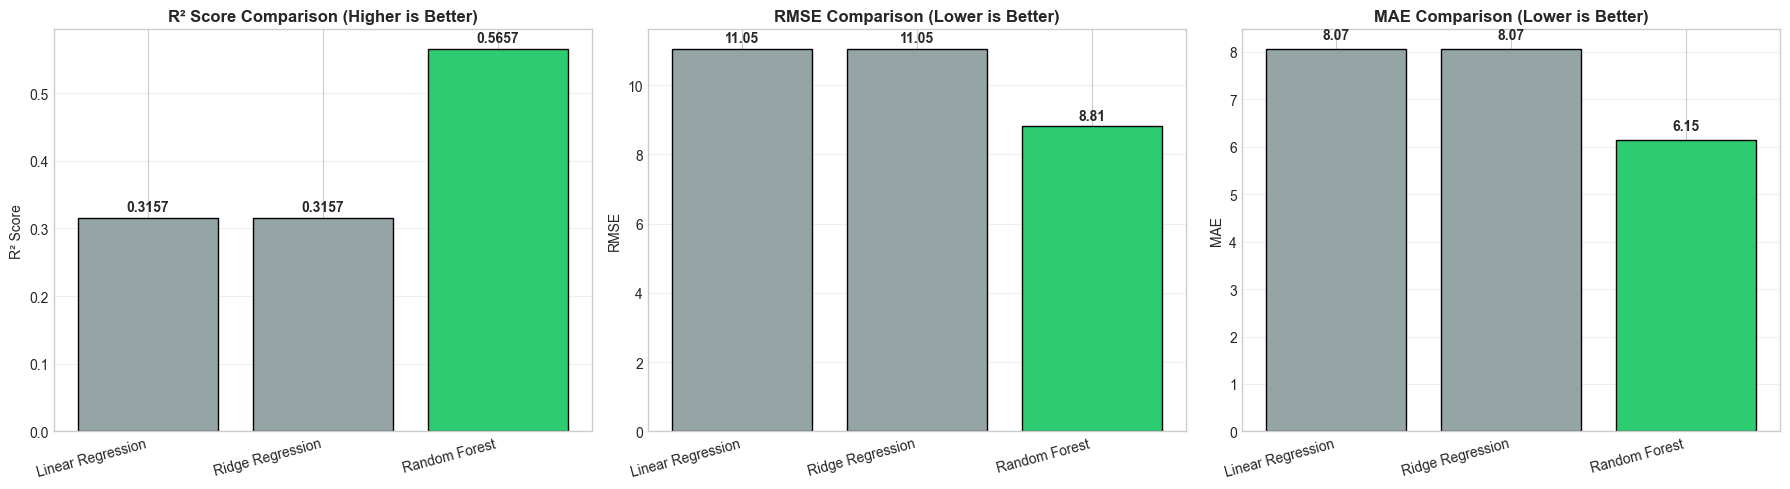

In [5]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² comparison
colors = ['#2ecc71' if model == best_model_name else '#95a5a6' for model in comparison_df.index]
axes[0].bar(range(len(comparison_df)), comparison_df['R²'], color=colors, edgecolor='black')
axes[0].set_xticks(range(len(comparison_df)))
axes[0].set_xticklabels(comparison_df.index, rotation=15, ha='right')
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² Score Comparison (Higher is Better)', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['R²']):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

# RMSE comparison
colors = ['#2ecc71' if model == best_model_name else '#95a5a6' for model in comparison_df.index]
axes[1].bar(range(len(comparison_df)), comparison_df['RMSE'], color=colors, edgecolor='black')
axes[1].set_xticks(range(len(comparison_df)))
axes[1].set_xticklabels(comparison_df.index, rotation=15, ha='right')
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE Comparison (Lower is Better)', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['RMSE']):
    axes[1].text(i, v + 0.2, f'{v:.2f}', ha='center', fontweight='bold')

# MAE comparison
colors = ['#2ecc71' if model == best_model_name else '#95a5a6' for model in comparison_df.index]
axes[2].bar(range(len(comparison_df)), comparison_df['MAE'], color=colors, edgecolor='black')
axes[2].set_xticks(range(len(comparison_df)))
axes[2].set_xticklabels(comparison_df.index, rotation=15, ha='right')
axes[2].set_ylabel('MAE')
axes[2].set_title('MAE Comparison (Lower is Better)', fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['MAE']):
    axes[2].text(i, v + 0.2, f'{v:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## Step 3: Hyperparameter Optimization

In [ ]:
from models.supervised.optimizer import optimize_model

# Get best model type
best_model_type = models_to_test[best_model_name]
best_metrics = results[best_model_name]

print(f"Optimizing {best_model_name}...")
print(f"Initial R²: {best_metrics['test_r2']:.4f}")
print(f"Initial MAE: {best_metrics['test_mae']:.4f}")
print("Running hyperparameter optimization...")

# Optimize
optimized_model, optimized_metrics, best_params = optimize_model(
    model_type=best_model_type,
    X=X_scaled,
    y=y.values,
    initial_metrics=best_metrics
)

print(f"Optimization complete!")
if best_params:
    print(f"Best parameters: {best_params}")

Optimizing Random Forest...

Initial R²: 0.5657
Initial MAE: 6.1498

Running hyperparameter optimization...
   Optimized R²: 0.5987 (Δ +0.0329)
   Optimized MAE: 5.8844 (Δ -0.2653)

Optimization complete!
Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


### Visualize Optimization Impact

OPTIMIZATION RESULTS
Metric   Before    After  Improvement
    R² 0.565741 0.598670     0.032929
  RMSE 8.805550 8.380356    -0.425194
   MAE 6.149753 5.884438    -0.265315


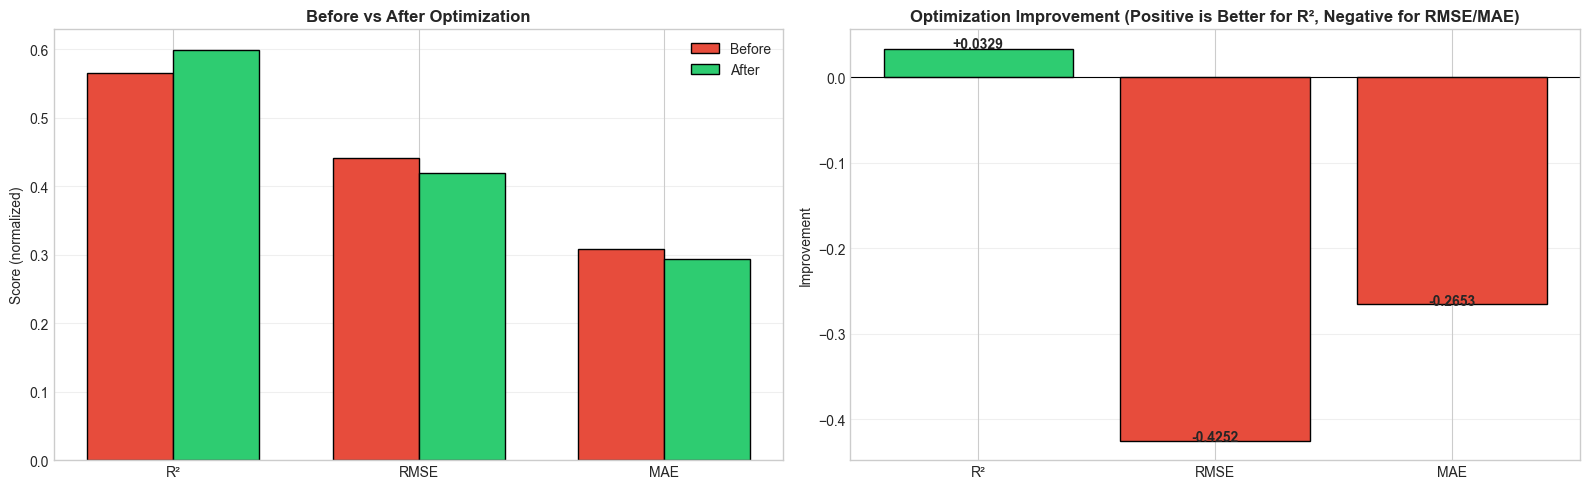

In [7]:
# Compare before/after optimization
if best_params:
    comparison_data = {
        'Metric': ['R²', 'RMSE', 'MAE'],
        'Before': [best_metrics['test_r2'], best_metrics['test_rmse'], best_metrics['test_mae']],
        'After': [optimized_metrics['r2'], optimized_metrics['rmse'], optimized_metrics['mae']]
    }
    opt_df = pd.DataFrame(comparison_data)
    opt_df['Improvement'] = opt_df['After'] - opt_df['Before']
    
    print("OPTIMIZATION RESULTS")
    print("="*60)
    print(opt_df.to_string(index=False))
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Before/After comparison
    x = np.arange(len(opt_df))
    width = 0.35
    
    # Normalize for visualization (R² is 0-1, RMSE and MAE are larger)
    before_norm = [opt_df.loc[0, 'Before'], opt_df.loc[1, 'Before']/20, opt_df.loc[2, 'Before']/20]
    after_norm = [opt_df.loc[0, 'After'], opt_df.loc[1, 'After']/20, opt_df.loc[2, 'After']/20]
    
    axes[0].bar(x - width/2, before_norm, width, label='Before', color='#e74c3c', edgecolor='black')
    axes[0].bar(x + width/2, after_norm, width, label='After', color='#2ecc71', edgecolor='black')
    axes[0].set_ylabel('Score (normalized)')
    axes[0].set_title('Before vs After Optimization', fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(opt_df['Metric'])
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Improvement
    colors = ['#2ecc71' if imp > 0 else '#e74c3c' if imp < 0 else '#95a5a6' for imp in opt_df['Improvement']]
    axes[1].bar(opt_df['Metric'], opt_df['Improvement'], color=colors, edgecolor='black')
    axes[1].axhline(0, color='black', linestyle='-', linewidth=0.8)
    axes[1].set_ylabel('Improvement')
    axes[1].set_title('Optimization Improvement (Positive is Better for R², Negative for RMSE/MAE)', fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(opt_df['Improvement']):
        axes[1].text(i, v + 0.001 if v > 0 else v - 0.001, f'{v:+.4f}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("No hyperparameters to optimize for this model.")

## Step 4: Final Model Performance

In [ ]:
# Make predictions with final model
predictions = optimized_model.predict(X_scaled)
errors = np.abs(y.values - predictions)
residuals = y.values - predictions

# Calculate final metrics
final_r2 = r2_score(y.values, predictions)
final_rmse = np.sqrt(mean_squared_error(y.values, predictions))
final_mae = mean_absolute_error(y.values, predictions)

# Accuracy thresholds
within_5 = (errors <= 5).sum() / len(errors) * 100
within_10 = (errors <= 10).sum() / len(errors) * 100
within_15 = (errors <= 15).sum() / len(errors) * 100

print("FINAL MODEL PERFORMANCE")
print("="*60)
print(f"Model: {best_model_name}")
print(f"Metrics:")
print(f"  R² Score: {final_r2:.4f} ({final_r2*100:.1f}% variance explained)")
print(f"  RMSE: {final_rmse:.4f}")
print(f"  MAE: {final_mae:.4f}")
print(f"Accuracy:")
print(f"  Within ±5 points: {within_5:.1f}%")
print(f"  Within ±10 points: {within_10:.1f}%")
print(f"  Within ±15 points: {within_15:.1f}%")
if best_params:
    print(f"Optimized Parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

FINAL MODEL PERFORMANCE
Model: Random Forest

Metrics:
  R² Score: 0.8349 (83.5% variance explained)
  RMSE: 5.5217
  MAE: 3.6687

Accuracy:
  Within ±5 points: 75.9%
  Within ±10 points: 94.2%
  Within ±15 points: 98.1%

Optimized Parameters:
  max_depth: 20
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 300


### Visualize Final Performance

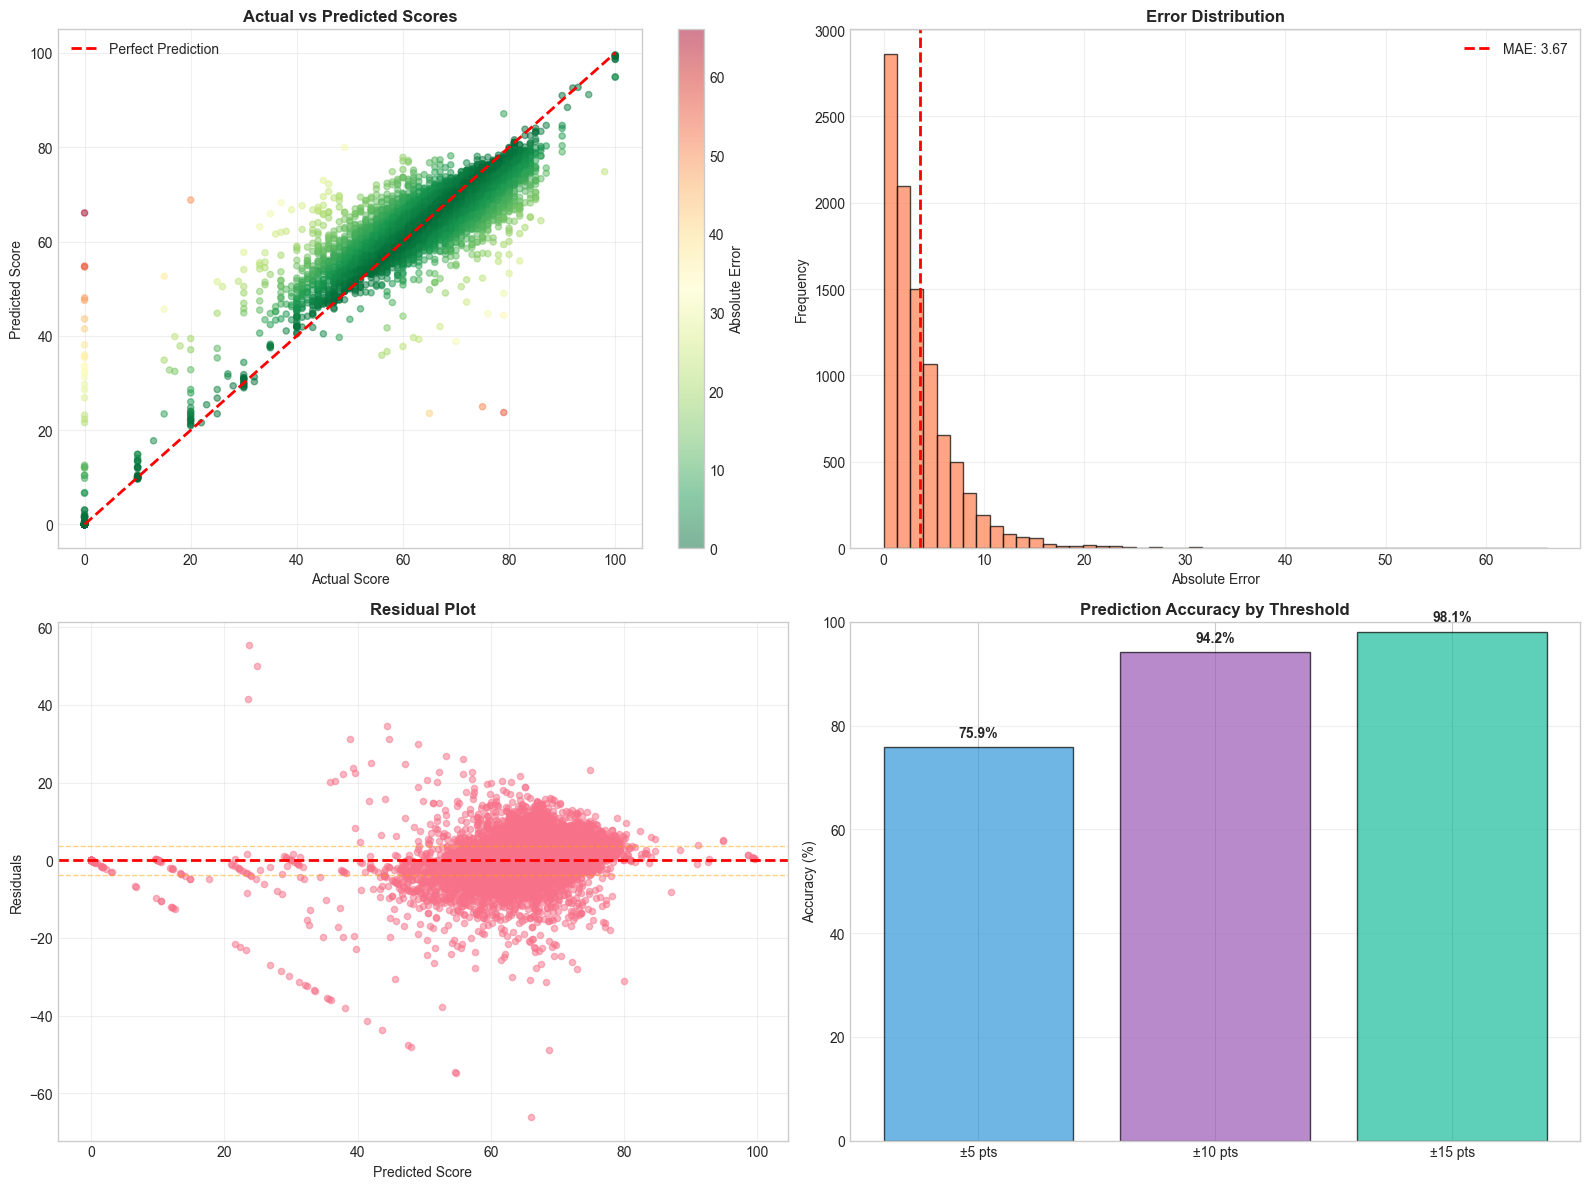

In [9]:
# Performance visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Actual vs Predicted
axes[0, 0].scatter(y.values, predictions, alpha=0.5, s=20, c=errors, cmap='RdYlGn_r')
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Score')
axes[0, 0].set_ylabel('Predicted Score')
axes[0, 0].set_title('Actual vs Predicted Scores', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)
cbar = plt.colorbar(axes[0, 0].collections[0], ax=axes[0, 0])
cbar.set_label('Absolute Error')

# Error distribution
axes[0, 1].hist(errors, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(final_mae, color='red', linestyle='--', linewidth=2, label=f'MAE: {final_mae:.2f}')
axes[0, 1].set_xlabel('Absolute Error')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Error Distribution', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Residual plot
axes[1, 0].scatter(predictions, residuals, alpha=0.5, s=20)
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].axhline(final_mae, color='orange', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 0].axhline(-final_mae, color='orange', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 0].set_xlabel('Predicted Score')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Residual Plot', fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Accuracy thresholds
thresholds = ['±5 pts', '±10 pts', '±15 pts']
accuracies = [within_5, within_10, within_15]
colors = ['#3498db', '#9b59b6', '#1abc9c']
axes[1, 1].bar(thresholds, accuracies, color=colors, edgecolor='black', alpha=0.7)
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].set_title('Prediction Accuracy by Threshold', fontweight='bold')
axes[1, 1].set_ylim([0, 100])
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(accuracies):
    axes[1, 1].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## Step 5: Feature Importance (Random Forest only)

TOP 15 MOST IMPORTANT FEATURES
                feature  importance
                revenue    0.208859
            log_revenue    0.204679
               budget_x    0.109905
             log_budget    0.102298
revenue_to_budget_ratio    0.073199
                 profit    0.049966
        overview_length    0.048221
             log_profit    0.032529
              crew_size    0.031457
        genre_animation    0.024449
            genre_drama    0.021531
           genre_horror    0.019246
       is_us_production    0.014384
            genre_count    0.009545
            genre_count    0.009520


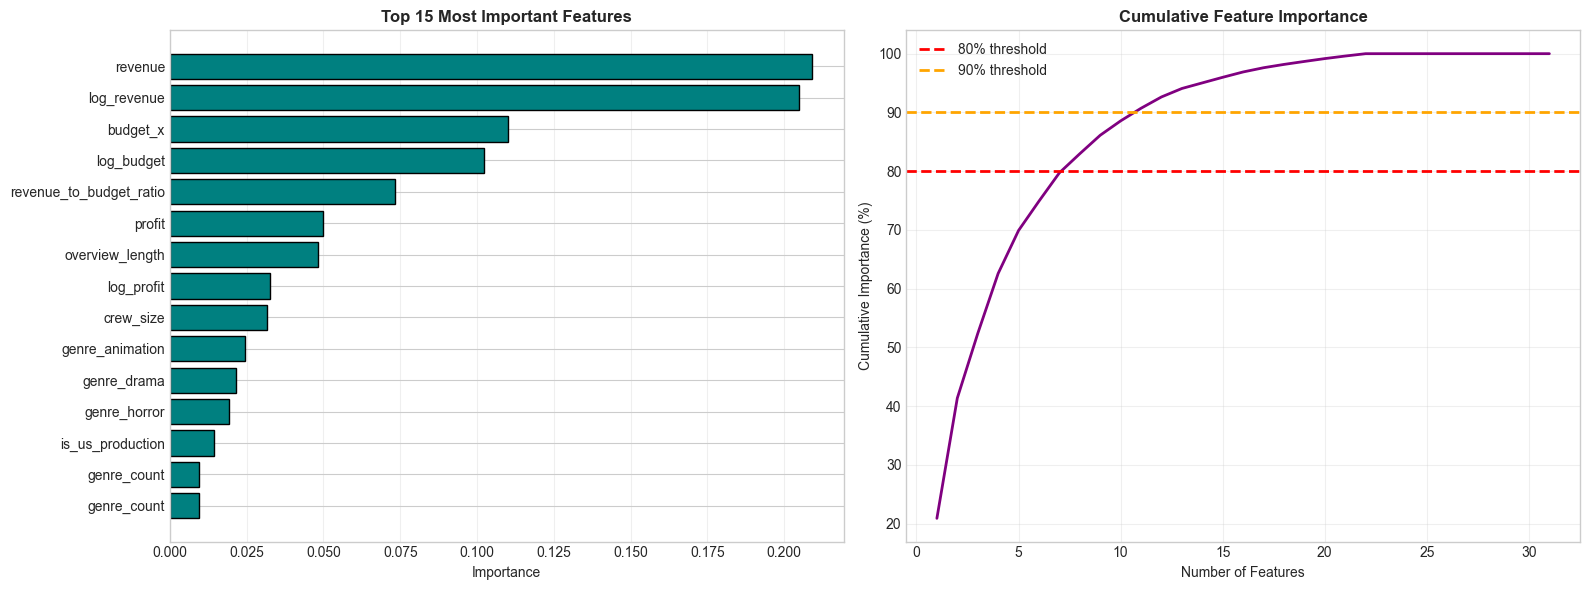


8 features explain 80% of the model's decisions


In [ ]:
# Feature importance (if available)
if hasattr(optimized_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': engineer.feature_names,
        'importance': optimized_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("TOP 15 MOST IMPORTANT FEATURES")
    print("="*60)
    print(importance_df.head(15).to_string(index=False))
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Top 15 features
    top_15 = importance_df.head(15)
    axes[0].barh(range(len(top_15)), top_15['importance'].values, color='teal', edgecolor='black')
    axes[0].set_yticks(range(len(top_15)))
    axes[0].set_yticklabels(top_15['feature'].values)
    axes[0].set_xlabel('Importance')
    axes[0].set_title('Top 15 Most Important Features', fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)
    
    # Cumulative importance
    cumsum = importance_df['importance'].cumsum() / importance_df['importance'].sum() * 100
    axes[1].plot(range(1, len(cumsum)+1), cumsum.values, linewidth=2, color='purple')
    axes[1].axhline(80, color='red', linestyle='--', linewidth=2, label='80% threshold')
    axes[1].axhline(90, color='orange', linestyle='--', linewidth=2, label='90% threshold')
    axes[1].set_xlabel('Number of Features')
    axes[1].set_ylabel('Cumulative Importance (%)')
    axes[1].set_title('Cumulative Feature Importance', fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    n_features_80 = (cumsum <= 80).sum() + 1
    print(f"{n_features_80} features explain 80% of the model's decisions")
else:
    print("Feature importance not available for this model type.")